based on the official documentation from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


### Step 0: **Import Libraries**


In [19]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
%matplotlib inline


Database:

Available links:

- https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages
- https://tatoeba.org/eng/downloads
- https://www.manythings.org/anki/

This demonstration uses a simple database of The English to French pairs  which is given in `data/eng-fra.txt`.
Link to download: https://download.pytorch.org/tutorial/data.zip




Data Representation:

    - each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index
    of the word).
    - Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/word-encoding.png)



### Step 1: **Prepare Vocabulary with the `Lang` Class**
   - **What the code does**: Defines a `Lang` class to handle language-specific vocabulary.
   - **How the code achieves this**:
     - Creates dictionaries to map words to unique indices (`word2index`) and indices back to words (`index2word`).
     - Tracks word frequencies (`word2count`) for potential filtering.
     - Adds words to the vocabulary as sentences are processed, including special tokens `SOS` (start of sentence) and `EOS` (end of sentence).



In [20]:
# Special tokens used to indicate the start and end of a sentence
SOS_token = 0  # Start of sentence token
EOS_token = 1  # End of sentence token

class Lang:
    def __init__(self, name):
        # Initialize the Lang class with the language name
        self.name = name

        # Dictionary to map words to unique indices
        self.word2index = {}

        # Dictionary to keep track of word frequencies (for word counts)
        self.word2count = {}

        # Dictionary to map indices back to words, with SOS and EOS tokens predefined
        self.index2word = {0: "SOS", 1: "EOS"}

        # Count of unique words, starting with 2 for SOS and EOS
        self.n_words = 2

    def addSentence(self, sentence):
        # Add each word in the sentence to the vocabulary
        # The sentence is split by spaces into individual words
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # If the word is not yet in the vocabulary
        if word not in self.word2index:
            # Add it to word2index with the current count as its index
            self.word2index[word] = self.n_words

            # Initialize the word's count in word2count dictionary
            self.word2count[word] = 1

            # Add the word to index2word for reverse lookup
            self.index2word[self.n_words] = word

            # Increment the word count
            self.n_words += 1
        else:
            # If the word already exists, just increment its count
            self.word2count[word] += 1


### Step 2: **Normalize Text Data**
   - **What the code does**: Normalizes sentences by removing accents, converting to lowercase, and removing non-letter characters.
   - **How the code achieves this**:
     - Converts Unicode characters to ASCII equivalents.
     - Uses regex to remove unwanted characters, making the text easier for the model to process.



In [21]:
import re
import unicodedata

# Convert a Unicode string to plain ASCII characters
def unicodeToAscii(s):
    # Normalize the Unicode string to 'NFD' form which separates characters and diacritics
    # Then, remove diacritics by filtering out characters in the 'Mn' (Mark, Nonspacing) category
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Normalize string: lowercase, trim, and remove non-letter characters
def normalizeString(s):
    # Convert to ASCII and lowercase the string, then remove any surrounding whitespace
    s = unicodeToAscii(s.lower().strip())

    # Add a space before punctuation like . ! ? to separate it from preceding words
    s = re.sub(r"([.!?])", r" \1", s)

    # Replace any sequence of non-alphabetic characters (excluding punctuation ! ?) with a single space
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)

    # Trim any extra whitespace from the beginning or end and return the result
    return s.strip()


### Step 3: **Read and Process Sentence Pairs**
   - **What the code does**: Reads sentence pairs from a file and splits them into language-specific pairs.
   - **How the code achieves this**:
     - Reads bilingual sentence pairs from a file, each pair separated by a tab (`\t`).
     - Splits and normalizes each sentence, returning processed pairs for training.



In [22]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file containing sentence pairs in two languages
    # The filename is assumed to be formatted as "lang1-lang2.txt"
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split each line by the tab character and normalize each sentence
    # The result is a list of sentence pairs, with each pair as [sentence_lang1, sentence_lang2]
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # If `reverse` is True, swap the language pairs
    # This makes lang2 the input language and lang1 the output language
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        # Otherwise, keep lang1 as input and lang2 as output
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


### Step 4: **Filter Sentence Pairs**
   - **What the code does**: Filters sentence pairs based on length and prefixes in English sentences.
   - **How the code achieves this**:
     - Limits each sentence in a pair to a maximum word count (`MAX_LENGTH`).
     - Checks if the English sentence starts with one of a set of common prefixes to focus on basic sentence structures.



In [23]:
# Define a maximum sentence length to filter out overly long sentences
MAX_LENGTH = 10

# Define English sentence prefixes of interest
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Function to filter a single sentence pair based on length and prefix
def filterPair(p):
    # Check if both sentences in the pair have fewer words than MAX_LENGTH
    # and if the English sentence starts with one of the defined prefixes
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

# Function to filter a list of pairs, returning only those that pass `filterPair`
def filterPairs(pairs):
    # Use list comprehension to apply `filterPair` to each pair in `pairs`
    return [pair for pair in pairs if filterPair(pair)]


### Step 5: **Prepare Data and Count Vocabulary**
   - **What the code does**: Adds words from each sentence to the vocabulary and counts them.
   - **How the code achieves this**:
     - Iterates over sentence pairs, adding each word to its respective language vocabulary.
     - Tracks vocabulary size (`n_words`) for both input and output languages.



In [24]:
def prepareData(lang1, lang2, reverse=False):
    # Read sentence pairs from a file and optionally reverse them
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))  # Display the initial number of pairs

    # Filter pairs to retain only those that meet length and prefix criteria
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))  # Show the count after filtering

    print("Counting words...")
    # Populate the vocabulary for both input and output languages by adding each sentence
    for pair in pairs:
        input_lang.addSentence(pair[0])  # Add words from the input sentence
        output_lang.addSentence(pair[1])  # Add words from the output sentence

    # Display the final word count for both languages
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)  # Print input language vocabulary size
    print(output_lang.name, output_lang.n_words)  # Print output language vocabulary size

    return input_lang, output_lang, pairs


### Step 6: **Define the Encoder Network (`EncoderRNN`)**
   - **What the code does**: Defines the encoder network, which processes the input sequence and produces a context vector.
   - **How the code achieves this**:
     - Embeds input tokens using an embedding layer to convert each token into a dense vector.
     - Uses a GRU (Gated Recurrent Unit) layer to process the sequence of embeddings, maintaining a hidden state across timesteps.
     - Outputs the final hidden state (context vector) that summarizes the input sequence and is passed to the decoder.



#### The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215), or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting
of two RNNs called the encoder and decoder. The encoder reads an input
sequence and outputs a single vector, and the decoder reads that vector
to produce an output sequence.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence `Je ne suis pas le chat noir` →
`I am not the black cat`. Most of the words in the input sentence have a
direct translation in the output sentence, but are in slightly different
orders, e.g. `chat noir` and `black cat`. Because of the `ne/pas`
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the \"meaning\" of the input sequence into a single
vector --- a single point in some N dimensional space of sentences.


#### The Encoder
===========

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/encoder-network.png)


In [25]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size  # Stores the hidden layer size for later use

        # Embedding layer maps input tokens (with indices) to dense vectors of size `hidden_size`
        self.embedding = nn.Embedding(input_size, hidden_size)

        # GRU layer processes the embedded tokens sequentially, producing an output and hidden state
        # Setting `batch_first=True` expects input in [batch_size, seq_length, hidden_size]
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

        # Dropout layer for regularization to prevent overfitting, applied on the embeddings
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        # Pass input tokens through the embedding layer and apply dropout
        embedded = self.dropout(self.embedding(input))
        print("Embedded Input Shape:", embedded.shape)  # Debug: view shape after embedding

        # Feed the embedded tokens into the GRU layer
        output, hidden = self.gru(embedded)
        print("GRU Output Shape:", output.shape)  # Debug: view shape of GRU output
        print("GRU Hidden State Shape:", hidden.shape)  # Debug: view shape of GRU hidden state

        # Return the full sequence of outputs and the final hidden state
        return output, hidden


The Decoder
===========

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.


### Step 7: **Define the Decoder Network (`DecoderRNN`)**
   - **What the code does**: Defines a basic decoder network to generate output sequences from the encoded context.
   - **How the code achieves this**:
     - Embeds the input tokens and feeds them into a GRU layer, similar to the encoder.
     - Generates predictions using a linear layer, mapping the hidden state to a vocabulary-sized output.
     - Applies a softmax activation to produce probability distributions over output tokens.




- In the simplest seq2seq decoder we use only last output of the encoder.
- This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

- At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string `<SOS>`
token, and the first hidden state is the context vector (the encoder\'s
last hidden state).

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/decoder-network.png)


In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        # Initialize the DecoderRNN model
        super(DecoderRNN, self).__init__()

        # Embedding layer to map output tokens to dense vectors of dimension `hidden_size`
        self.embedding = nn.Embedding(output_size, hidden_size)

        # GRU layer that processes the embedded tokens
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

        # Linear layer to map the GRU output to the vocabulary size, producing logits
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        # `encoder_outputs` holds the sequence of hidden states from the encoder
        # `encoder_hidden` is the final hidden state from the encoder (context vector)
        # `target_tensor` is the ground truth sequence used for teacher forcing

        # Get the batch size from encoder outputs
        batch_size = encoder_outputs.size(0)

        # Initialize decoder input with the `SOS_token` for each sequence in the batch
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # Set initial hidden state of the decoder to be the final hidden state of the encoder
        decoder_hidden = encoder_hidden

        # List to accumulate decoder outputs for each time step
        decoder_outputs = []

        # Loop over each timestep up to a maximum sequence length `MAX_LENGTH`
        for i in range(MAX_LENGTH):
            # Perform one decoding step (one timestep)
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)

            # Collect the output for this timestep
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # If teacher forcing is enabled, use the target sequence as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing, use the model's own prediction as the next input
                _, topi = decoder_output.topk(1)  # Get the highest-probability token index
                decoder_input = topi.squeeze(-1).detach()  # Detach from computation graph

        # Concatenate outputs along the sequence dimension to create the final output
        decoder_outputs = torch.cat(decoder_outputs, dim=1)

        # Apply log softmax to get log-probabilities across the vocabulary
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

        # Return the output tensor and the final hidden state, `None` for compatibility
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input, hidden):
        # Embedding layer to map input token to a dense vector
        output = self.embedding(input)

        # Apply ReLU activation to the embedded input
        output = F.relu(output)

        # Pass through the GRU with the current hidden state
        output, hidden = self.gru(output, hidden)

        # Map GRU output to the vocabulary space using a linear layer
        output = self.out(output)

        # Return the output and updated hidden state for this timestep
        return output, hidden


### Step 8: **Define Bahdanau Attention Mechanism**
   - **What the code does**: Implements Bahdanau attention to calculate attention scores for each decoder step.
   - **How the code achieves this**:
     - Applies linear transformations to the decoder hidden state (query) and encoder outputs (keys).
     - Calculates scores by combining the query and keys, followed by a softmax layer to produce attention weights.
     - Creates a context vector for each decoder step based on weighted encoder outputs.



##### Attention Decoder
=================

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to \"focus\" on a different part of
the encoder\'s outputs for every step of the decoder\'s own outputs.
First we calculate a set of *attention weights*. These will be
multiplied by the encoder output vectors to create a weighted
combination. The result (called `attn_applied` in the code) should
contain information about that specific part of the input sequence, and
thus help the decoder choose the right output words.


Calculating the attention weights is done with another feed-forward
layer `attn`, using the decoder\'s input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/attention-decoder-network.png)

Bahdanau attention, also known as additive attention, is a commonly used
attention mechanism in sequence-to-sequence models, particularly in
neural machine translation tasks. It was introduced by Bahdanau et al.
in their paper titled [Neural Machine Translation by Jointly Learning to
Align and Translate](https://arxiv.org/pdf/1409.0473.pdf). This
attention mechanism employs a learned alignment model to compute
attention scores between the encoder and decoder hidden states. It
utilizes a feed-forward neural network to calculate alignment scores.

However, there are alternative attention mechanisms available, such as
Luong attention, which computes attention scores by taking the dot
product between the decoder hidden state and the encoder hidden states.
It does not involve the non-linear transformation used in Bahdanau
attention.

In this tutorial, we will be using Bahdanau attention. However, it would
be a valuable exercise to explore modifying the attention mechanism to
use Luong attention.


In [27]:
#The BahdanauAttention class implements the attention mechanism, which calculates attention scores based on the decoder's hidden state (query) and the encoder's outputs (keys).

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        # Linear transformations to prepare the query and keys for score calculation
        self.Wa = nn.Linear(hidden_size, hidden_size)  # Applies to the decoder hidden state (query)
        self.Ua = nn.Linear(hidden_size, hidden_size)  # Applies to encoder outputs (keys)
        self.Va = nn.Linear(hidden_size, 1)           # Reduces the combined representation to a score

    def forward(self, query, keys):
        # Calculate scores with the Bahdanau formula: Va * tanh(Wa * query + Ua * keys)
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))

        # Adjust the shape of scores for compatibility in batch processing
        scores = scores.squeeze(2).unsqueeze(1)

        # Calculate attention weights by applying softmax to the scores
        weights = F.softmax(scores, dim=-1)

        # Calculate the context vector as a weighted sum of the encoder outputs
        context = torch.bmm(weights, keys)

        return context, weights



### Step 9: **Build the Attention-Based Decoder**
   - **What the code does**: Defines a decoder with attention to generate each output token based on context.
   - **How the code achieves this**:
     - Uses an embedding layer to convert input tokens to dense vectors.
     - Applies Bahdanau attention to produce a context vector from encoder outputs.
     - Combines context and embedded inputs to produce the output sequence.



In [28]:

# The AttnDecoderRNN class is an attention-based decoder using Bahdanau's attention mechanism. It generates the next token in the sequence using both the previous hidden state and the context vector derived from attention.
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()

        # Embedding layer to map output tokens to dense vectors
        self.embedding = nn.Embedding(output_size, hidden_size)

        # The attention layer using Bahdanau attention
        self.attention = BahdanauAttention(hidden_size)

        # GRU layer that takes the concatenated context and embedded input
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)

        # Linear layer to produce the final token logits
        self.out = nn.Linear(hidden_size, output_size)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        # Initialize decoder input with the `SOS_token` for each sequence in the batch
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # Initialize decoder hidden state with the encoder's final hidden state
        decoder_hidden = encoder_hidden

        # Lists to hold outputs and attention weights at each time step
        decoder_outputs = []
        attentions = []

        # Process each time step up to `MAX_LENGTH`
        for i in range(MAX_LENGTH):
            # Perform a single decoding step with attention
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # Collect the output and attention weights
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Use the target tensor as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use the model's own prediction
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        # Concatenate all time step outputs and apply log softmax
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

        # Concatenate all attention weights for inspection/visualization
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        # Embed the decoder's current input and apply dropout
        embedded = self.dropout(self.embedding(input))

        # Prepare the query by reshaping the hidden state for attention calculation
        query = hidden.permute(1, 0, 2)

        # Use the Bahdanau attention layer to compute context vector and attention weights
        context, attn_weights = self.attention(query, encoder_outputs)

        # Concatenate the embedded input and context vector along the last dimension
        input_gru = torch.cat((embedded, context), dim=2)

        # Pass the concatenated tensor through the GRU
        output, hidden = self.gru(input_gru, hidden)

        # Map the GRU output to vocabulary size using the linear layer
        output = self.out(output)

        return output, hidden, attn_weights



### Step 10: **Convert Sentences to Index Tensors and Batch Preparation**
   - **What the code does**: Converts sentences to index tensors and organizes them into batches.
   - **How the code achieves this**:
     - Maps words in each sentence to their vocabulary indices.
     - Adds an `EOS` token at the end of each sentence.
     - Pads sentences to a fixed length, preparing them as tensors for efficient batch processing.



In [29]:
def indexesFromSentence(lang, sentence):
    # Convert each word in the sentence into its index from the language's vocabulary
    # The `lang.word2index` dictionary maps words to their unique indices
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    # Convert a sentence into a tensor of word indices
    # Step 1: Use `indexesFromSentence` to get the list of word indices for the sentence
    indexes = indexesFromSentence(lang, sentence)

    # Step 2: Append the EOS (end of sentence) token to mark the end of the sentence
    indexes.append(EOS_token)

    # Step 3: Convert the list of indices to a PyTorch tensor of type `torch.long`
    # `.view(1, -1)` reshapes it to a 2D tensor with 1 row and as many columns as there are indices
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    # Convert a pair of sentences (input and target) into a tuple of tensors
    # Step 1: Convert the input sentence (first element of the pair) to a tensor
    input_tensor = tensorFromSentence(input_lang, pair[0])

    # Step 2: Convert the target sentence (second element of the pair) to a tensor
    target_tensor = tensorFromSentence(output_lang, pair[1])

    # Step 3: Return a tuple containing both tensors, (input_tensor, target_tensor)
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    # Prepare the language data and read sentence pairs
    # This function assumes that `prepareData` returns the input and output language objects
    # and a list of sentence pairs, each represented as a pair of strings
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    # Initialize numpy arrays to store the indices of input and target sentences
    # `n` is the number of sentence pairs; each array has shape [n, MAX_LENGTH]
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    # For each sentence pair, convert sentences into lists of word indices
    for idx, (inp, tgt) in enumerate(pairs):
        # Convert each word in the input sentence to its index and add EOS token
        inp_ids = indexesFromSentence(input_lang, inp)

        # Convert each word in the target sentence to its index and add EOS token
        tgt_ids = indexesFromSentence(output_lang, tgt)

        # Append EOS token to indicate the end of the sentence
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)

        # Populate `input_ids` and `target_ids` arrays for the current sentence pair
        # Slice only the length of `inp_ids` or `tgt_ids` for each sentence pair
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # Convert numpy arrays to PyTorch tensors and load them to the specified device
    # Create a TensorDataset object that combines input and target tensors for easy batching
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    # Define a RandomSampler to shuffle the dataset at each epoch
    train_sampler = RandomSampler(train_data)

    # Create a DataLoader to handle batching and shuffling
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Return the language objects and the DataLoader with batched input-target pairs
    return input_lang, output_lang, train_dataloader


### Step 11: **Define the Training Loop for a Single Epoch**
   - **What the code does**: Trains the model for a single epoch by processing each batch.
   - **How the code achieves this**:
     - Processes input sentences through the encoder and generates predictions with the decoder.
     - Calculates the loss and backpropagates to update model weights.
     - Optimizes the model using the encoder and decoder optimizers.



- To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the `<SOS>` token as its first input, and the last hidden state of the
encoder as its first hidden state.

- \"Teacher forcing\" is the concept of using the real target outputs as
each next input, instead of using the decoder\'s guess as the next
input. Using teacher forcing causes it to converge faster but [when the
trained network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation
-intuitively it has learned to represent the output grammar and can
\"pick up\" the meaning once the teacher tells it the first few words,
but it has not properly learned how to create the sentence from the
translation in the first place.

Because of the freedom PyTorch\'s autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
`teacher_forcing_ratio` up to use more of it.


In [30]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
                decoder_optimizer, criterion):

    # Initialize variable to accumulate the total loss across all batches
    total_loss = 0

    # Iterate over each batch in the dataloader
    for data in dataloader:
        # Unpack the input and target tensors from the current batch
        input_tensor, target_tensor = data

        # Zero out the gradients for both optimizers to avoid accumulation from previous steps
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Forward pass through the encoder
        # `encoder_outputs` holds the sequence of hidden states for all input tokens
        # `encoder_hidden` is the final hidden state of the encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Forward pass through the decoder, providing it with encoder outputs and hidden state
        # `decoder_outputs` holds the predicted sequence logits for each timestep
        # `target_tensor` is passed to enable teacher forcing during training
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # Compute the loss between the predicted sequence (`decoder_outputs`) and the target
        # `view(-1, decoder_outputs.size(-1))` flattens both tensors for compatibility with `criterion`
        # - `decoder_outputs` shape: [batch_size * seq_length, vocab_size]
        # - `target_tensor` shape: [batch_size * seq_length]
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )

        # Backward pass to compute gradients for both encoder and decoder
        loss.backward()

        # Update model parameters for both encoder and decoder based on computed gradients
        encoder_optimizer.step()
        decoder_optimizer.step()

        # Accumulate the loss for this batch
        total_loss += loss.item()

    # Calculate the average loss across all batches in the epoch
    return total_loss / len(dataloader)


### Step 12: **Track Training Time**
   - **What the code does**: Tracks elapsed time and estimated remaining time.
   - **How the code achieves this**:
     - Calculates time spent on each batch and estimates total training time.
     - Uses a utility function to convert seconds into minutes and seconds for readability.



In [31]:
import time
import math

def asMinutes(s):
    # Convert a time duration from seconds to a 'minutes seconds' format
    # Step 1: Calculate the number of whole minutes in `s`
    m = math.floor(s / 60)

    # Step 2: Subtract the number of seconds that make up the calculated minutes
    s -= m * 60

    # Step 3: Format the result as 'Xm Ys', where X is minutes and Y is seconds
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    # Calculate elapsed time and estimate remaining time
    # `since` is the start time in seconds (e.g., from `time.time()` at the start of training)
    # `percent` is the completion percentage of the process (e.g., a fraction of batches completed)

    # Step 1: Get the current time and calculate the elapsed time since `since`
    now = time.time()
    s = now - since

    # Step 2: Estimate the total time by dividing elapsed time by percent completion
    es = s / percent

    # Step 3: Calculate the remaining time by subtracting elapsed time from estimated total time
    rs = es - s

    # Step 4: Return a formatted string showing elapsed time and estimated remaining time
    # Elapsed time is `asMinutes(s)`, remaining time is `asMinutes(rs)`
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


### Step 13: **Implement Full Training Process Across Multiple Epochs**
   - **What the code does**: Trains the model over multiple epochs and prints progress.
   - **How the code achieves this**:
     - Repeats the single-epoch process for the specified number of epochs.
     - Prints average loss and training progress at intervals for monitoring.
     - Collects loss values to visualize model improvement over time.



The whole training process looks like this:

-   Start a timer
-   Initialize optimizers and criterion
-   Create set of training pairs
-   Start empty losses array for plotting

Then we call `train` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.


In [32]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
          print_every=100, plot_every=100):

    # Record the start time to track elapsed time during training
    start = time.time()

    # List to accumulate losses for plotting purposes
    plot_losses = []

    # Track cumulative loss for printing and plotting averages
    print_loss_total = 0  # Reset every `print_every`
    plot_loss_total = 0   # Reset every `plot_every`

    # Initialize optimizers for encoder and decoder with the given learning rate
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Define the loss function as Negative Log Likelihood Loss (useful for classification tasks)
    criterion = nn.NLLLoss()

    # Loop over each epoch
    for epoch in range(1, n_epochs + 1):
        # Train for one epoch and get the average loss for the epoch
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Accumulate loss for printing and plotting purposes
        print_loss_total += loss
        plot_loss_total += loss

        # Print average loss every `print_every` epochs
        if epoch % print_every == 0:
            # Calculate average loss over the last `print_every` epochs
            print_loss_avg = print_loss_total / print_every

            # Reset `print_loss_total` after printing
            print_loss_total = 0

            # Print elapsed time, epoch number, progress percentage, and average loss
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                         epoch, epoch / n_epochs * 100, print_loss_avg))

        # Accumulate loss for plotting every `plot_every` epochs
        if epoch % plot_every == 0:
            # Calculate average loss for plotting over the last `plot_every` epochs
            plot_loss_avg = plot_loss_total / plot_every

            # Append the average loss to `plot_losses` for later visualization
            plot_losses.append(plot_loss_avg)

            # Reset `plot_loss_total` after updating the plot list
            plot_loss_total = 0

    # Display the plot of training losses over time after completing all epochs
    showPlot(plot_losses)


### Step 14: **Plot Training Loss**
   - **What the code does**: Plots training loss over epochs to monitor convergence.
   - **How the code achieves this**:
     - Uses Matplotlib to plot the list of accumulated loss values.
     - Configures tick spacing and displays a color bar for clearer visualization.



In [33]:
import matplotlib.pyplot as plt
# Switch backend to 'agg' for rendering plots in environments without a display (e.g., servers)
plt.switch_backend('agg')

import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    # Create a new figure for the plot
    plt.figure()

    # Create a subplot within the figure
    fig, ax = plt.subplots()

    # Set the y-axis ticks to occur at regular intervals, here every 0.2 units
    # `MultipleLocator` provides evenly spaced ticks on the y-axis for better readability
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)

    # Plot the points (e.g., training losses) as a line plot
    plt.plot(points)


### Step 15: **Evaluate the Model on New Sentences**
   - **What the code does**: Generates predictions for a given input sentence.
   - **How the code achieves this**:
     - Converts the input sentence into a tensor of word indices.
     - Processes the sentence through the encoder and decoder.
     - Converts the predicted indices back into words, returning the decoded sentence.



In [34]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    # Turn off gradient computation, since we are in evaluation mode (no backpropagation)
    with torch.no_grad():
        # Convert the input sentence into a tensor of word indices
        input_tensor = tensorFromSentence(input_lang, sentence)

        # Pass the input tensor through the encoder to get encoder outputs and final hidden state
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Pass the encoder outputs and final hidden state to the decoder
        # Decoder outputs are the predicted sequence logits, hidden state, and attention weights
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # Get the indices of the highest-probability tokens at each timestep in the output sequence
        # `topk(1)` retrieves the top prediction at each step
        _, topi = decoder_outputs.topk(1)

        # Flatten the list of indices for readability and processing
        decoded_ids = topi.squeeze()

        # Initialize an empty list to store the decoded words
        decoded_words = []

        # Convert each token index in `decoded_ids` back to words until an EOS token is encountered
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                # If EOS token is found, append `<EOS>` and stop decoding
                decoded_words.append('<EOS>')
                break
            # Otherwise, convert index to word using `output_lang.index2word` and append
            decoded_words.append(output_lang.index2word[idx.item()])

    # Return the list of decoded words and the attention weights from the decoder
    return decoded_words, decoder_attn


### Step 16: **Evaluate Model on Random Sentence Pairs for Qualitative Assessment**
   - **What the code does**: Selects random sentence pairs and evaluates the model's predictions.
   - **How the code achieves this**:
     - Selects random pairs and uses the `evaluate` function to generate predictions.
     - Prints the input sentence, target sentence, and predicted output for each pair.



In [42]:
def evaluateRandomly(encoder, decoder, pairs, n=10):
    for i in range(n):
        # Select a random sentence pair (input and target) from the dataset
        pair = random.choice(pairs)
        print('>', pair[0])  # Input sentence in the source language
        print('=', pair[1])  # Target sentence in the target language

        # Use the evaluate function to predict the output for the input sentence
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)

        # Print the model's predicted translation
        print('<', output_sentence)
        print('')  # Blank line for readability between examples


### Step 17: **Initialize and Train the Model**
   - **What the code does**: Initializes the encoder and decoder models and trains them.
   - **How the code achieves this**:
     - Sets up hyperparameters like `hidden_size` and `batch_size`.
     - Initializes the encoder, attention-based decoder, and optimizers.
     - Trains the model over multiple epochs, tracking progress and storing losses.



In [36]:
hidden_size = 128
batch_size = 32

# Prepare the data and load it into a DataLoader for batching
# `input_lang` and `output_lang` are language objects holding vocabulary info for input and output
# `train_dataloader` batches and shuffles the training data with the specified `batch_size`
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

# Initialize the encoder with the size of the input language vocabulary and the `hidden_size`
# `input_lang.n_words` is the vocabulary size of the source language
# Move the encoder to the specified device (e.g., GPU if available)
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)

# Initialize the decoder with attention, using `hidden_size` and the output vocabulary size
# `output_lang.n_words` is the vocabulary size of the target language
# Move the decoder to the specified device
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# Train the encoder-decoder model for 80 epochs
# `train_dataloader` provides batches for training, and `print_every` controls the print frequency
# `plot_every` controls the frequency of updating loss for plotting
train(train_dataloader, encoder, decoder, n_epochs=80, print_every=5, plot_every=5)


Streaming output truncated to the last 5000 lines.
GRU Hidden State Shape: torch.Size([1, 32, 128])
Embedded Input Shape: torch.Size([32, 10, 128])
GRU Output Shape: torch.Size([32, 10, 128])
GRU Hidden State Shape: torch.Size([1, 32, 128])
Embedded Input Shape: torch.Size([32, 10, 128])
GRU Output Shape: torch.Size([32, 10, 128])
GRU Hidden State Shape: torch.Size([1, 32, 128])
Embedded Input Shape: torch.Size([32, 10, 128])
GRU Output Shape: torch.Size([32, 10, 128])
GRU Hidden State Shape: torch.Size([1, 32, 128])
Embedded Input Shape: torch.Size([32, 10, 128])
GRU Output Shape: torch.Size([32, 10, 128])
GRU Hidden State Shape: torch.Size([1, 32, 128])
Embedded Input Shape: torch.Size([32, 10, 128])
GRU Output Shape: torch.Size([32, 10, 128])
GRU Hidden State Shape: torch.Size([1, 32, 128])
Embedded Input Shape: torch.Size([32, 10, 128])
GRU Output Shape: torch.Size([32, 10, 128])
GRU Hidden State Shape: torch.Size([1, 32, 128])
Embedded Input Shape: torch.Size([32, 10, 128])
GRU Ou

Set dropout layers to `eval` mode


In [49]:
# Define and prepare data
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

encoder.eval()
decoder.eval()

evaluateRandomly(encoder, decoder, pairs)


Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
> c est moi qui paie
= i m buying
Embedded Input Shape: torch.Size([1, 6, 128])
GRU Output Shape: torch.Size([1, 6, 128])
GRU Hidden State Shape: torch.Size([1, 1, 128])
< i m paying <EOS>

> nous sommes comediens
= we re comedians
Embedded Input Shape: torch.Size([1, 4, 128])
GRU Output Shape: torch.Size([1, 4, 128])
GRU Hidden State Shape: torch.Size([1, 1, 128])
< we re comedians <EOS>

> je suis desole de t avoir blessee
= i m sorry i hurt you
Embedded Input Shape: torch.Size([1, 8, 128])
GRU Output Shape: torch.Size([1, 8, 128])
GRU Hidden State Shape: torch.Size([1, 1, 128])
< i m sorry i hurt you <EOS>

> je ne suis pas prete a mourir
= i m not ready to die
Embedded Input Shape: torch.Size([1, 8, 128])
GRU Output Shape: torch.Size([1, 8, 128])
GRU Hidden State Shape: torch.Size([1, 1, 128])
< i m not ready to die <EOS>

> il est intimide par les belles f

### Step 18: **Evaluate and Visualize Attention Weights**
   - **What the code does**: Visualizes attention weights over the input sequence for each generated word.
   - **How the code achieves this**:
     - Displays a heatmap of attention weights for each output word over the input tokens.
     - Uses labels for clarity, helping interpret the focus of the model at each decoding step.

Embedded Input Shape: torch.Size([1, 10, 128])
GRU Output Shape: torch.Size([1, 10, 128])
GRU Hidden State Shape: torch.Size([1, 1, 128])
input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


<ipython-input-48-f95aea4a46bc>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-48-f95aea4a46bc>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


<Figure size 640x480 with 0 Axes>

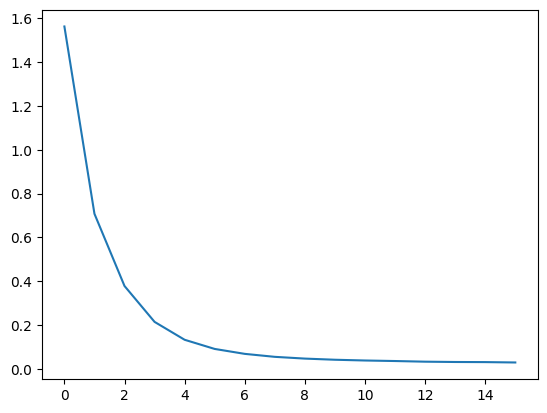

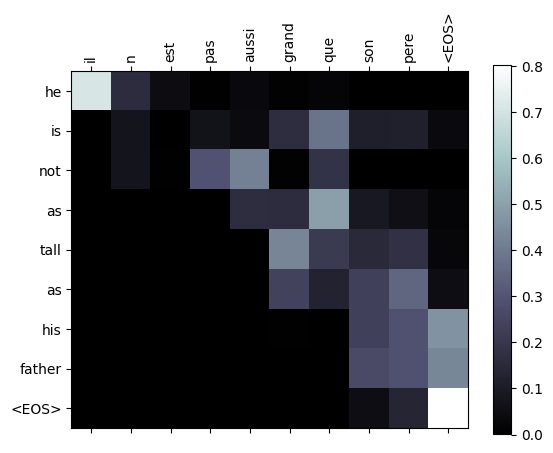

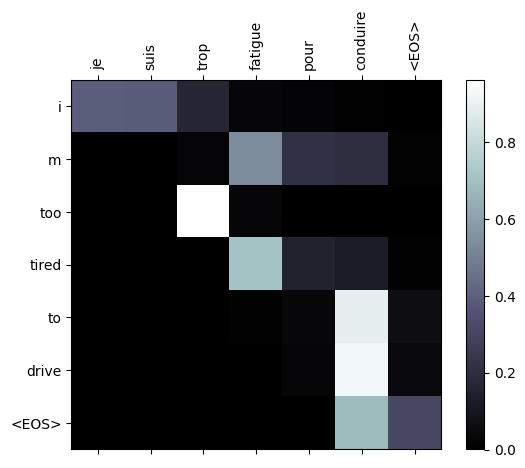

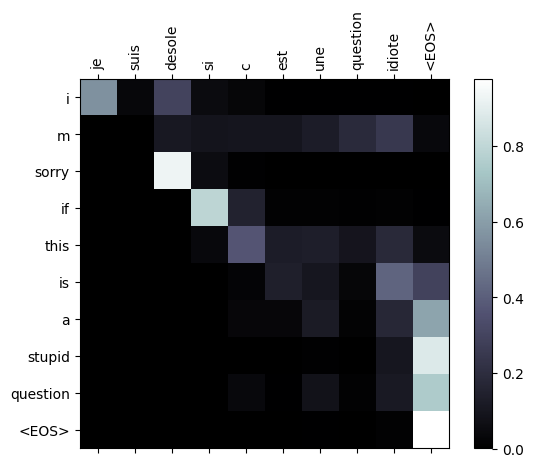

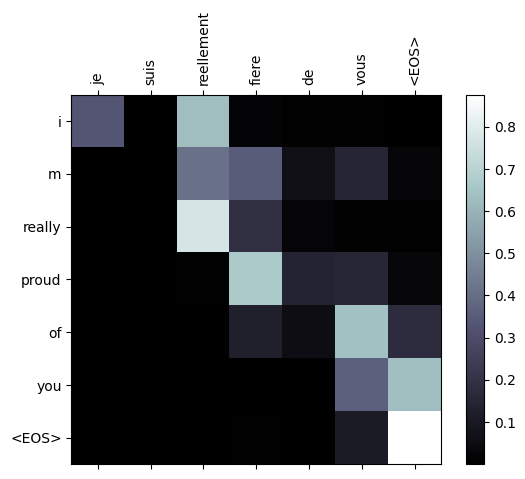

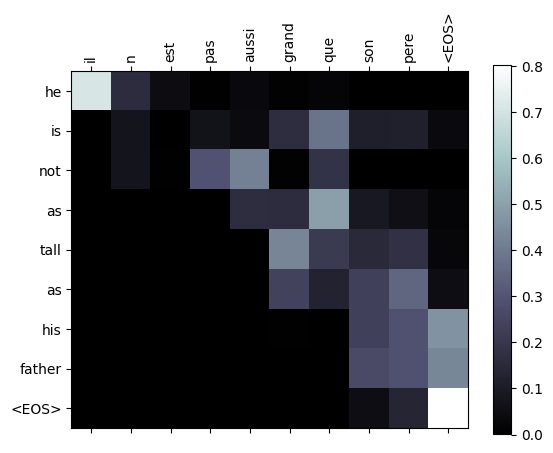

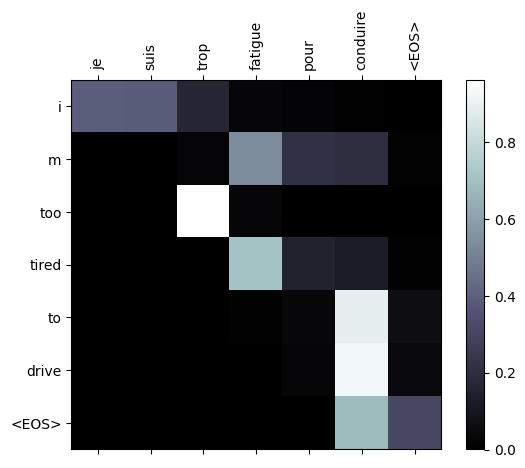

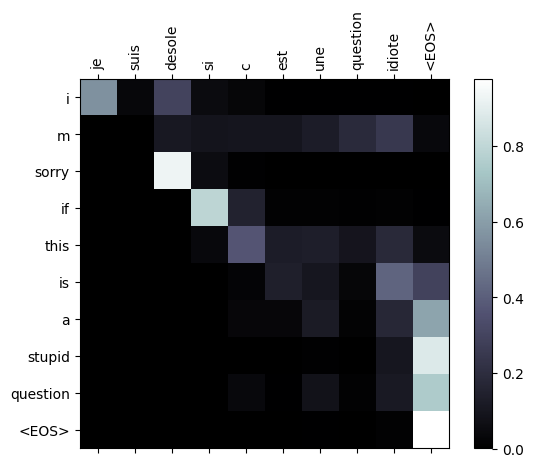

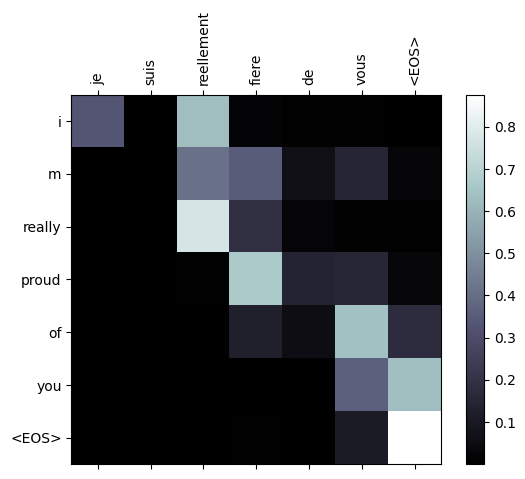

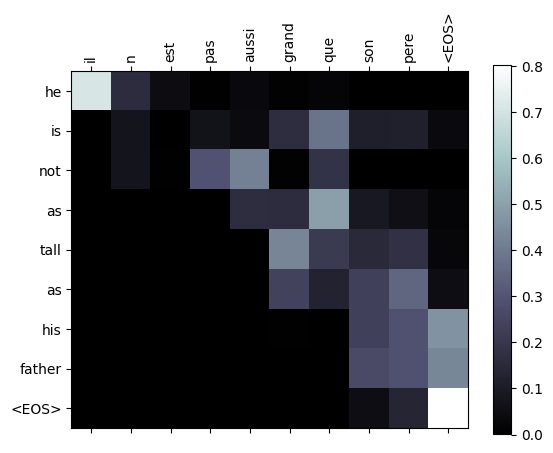



Embedded Input Shape: torch.Size([1, 7, 128])
GRU Output Shape: torch.Size([1, 7, 128])
GRU Hidden State Shape: torch.Size([1, 1, 128])
input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>


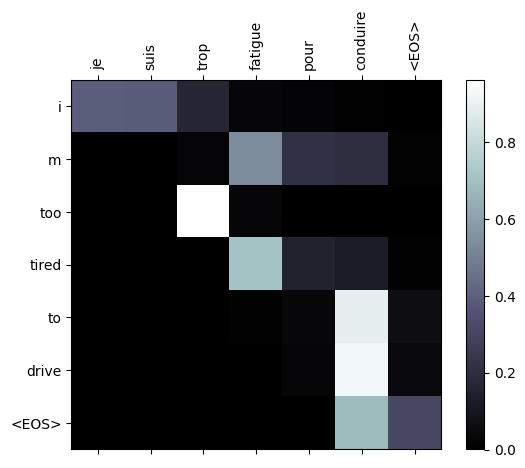



Embedded Input Shape: torch.Size([1, 10, 128])
GRU Output Shape: torch.Size([1, 10, 128])
GRU Hidden State Shape: torch.Size([1, 1, 128])
input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


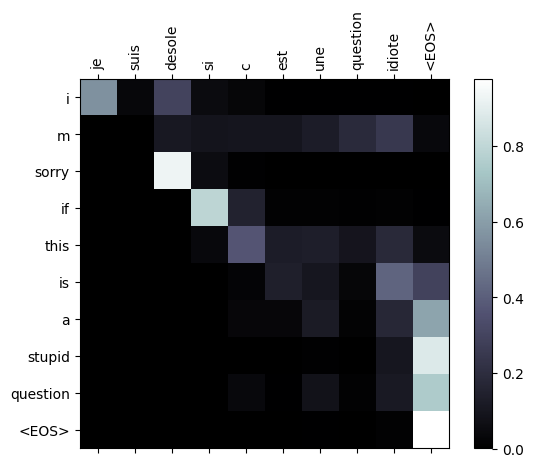



Embedded Input Shape: torch.Size([1, 7, 128])
GRU Output Shape: torch.Size([1, 7, 128])
GRU Hidden State Shape: torch.Size([1, 1, 128])
input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


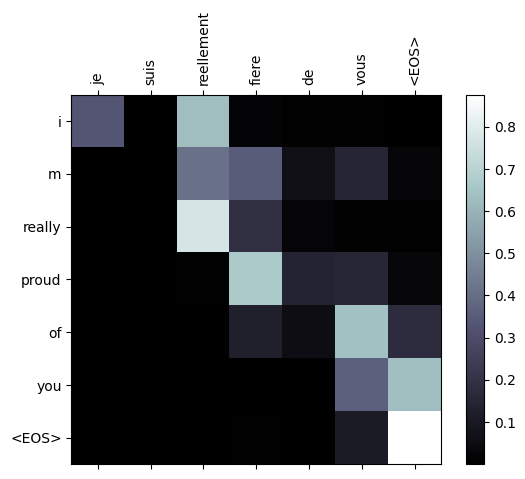

In [48]:
def showAttention(input_sentence, output_words, attentions):
    # Create a new figure for the attention plot
    fig = plt.figure()

    # Add a subplot to the figure with 111 (single subplot layout)
    ax = fig.add_subplot(111)

    # Display the attention matrix as a grayscale image
    # Convert `attentions` to a NumPy array and use the 'bone' colormap for visual clarity
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')

    # Add a color bar to the right of the plot to indicate the intensity of attention values
    fig.colorbar(cax)

    # Set up x-axis labels (input sentence tokens with <EOS> token at the end)
    # `split(' ')` splits the sentence into words, and `[''] + ...` aligns labels with the ticks
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)

    # Set up y-axis labels (output sentence tokens)
    ax.set_yticklabels([''] + output_words)

    # Set major tick locators to display every token on both x and y axes
    # `MultipleLocator(1)` sets a tick at every position (1 unit apart)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Display the plot
    plt.show()

def evaluateAndShowAttention(input_sentence):
    # Evaluate the model on the input sentence to get the predicted words and attention weights
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)

    # Print the input sentence
    print('input =', input_sentence)

    # Print the model's output as a space-separated string of predicted words
    print('output =', ' '.join(output_words))

    # Display the attention plot using the `showAttention` function
    # We only take the relevant attention part (`attentions[0, :len(output_words), :]`)
    # which corresponds to the actual output sequence length
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

# Evaluate and visualize attention for specific example sentences
evaluateAndShowAttention('il n est pas aussi grand que son pere')
print('\n')
evaluateAndShowAttention('je suis trop fatigue pour conduire')
print('\n')
evaluateAndShowAttention('je suis desole si c est une question idiote')
print('\n')
evaluateAndShowAttention('je suis reellement fiere de vous')
print('\n')
